In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS= 3
EPOCHS= 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 2 0 2 0 1 0 0 1 0 1 1 1 1 1 0 2 1 1 0 0 0 2 1 0 2 1 1 0]


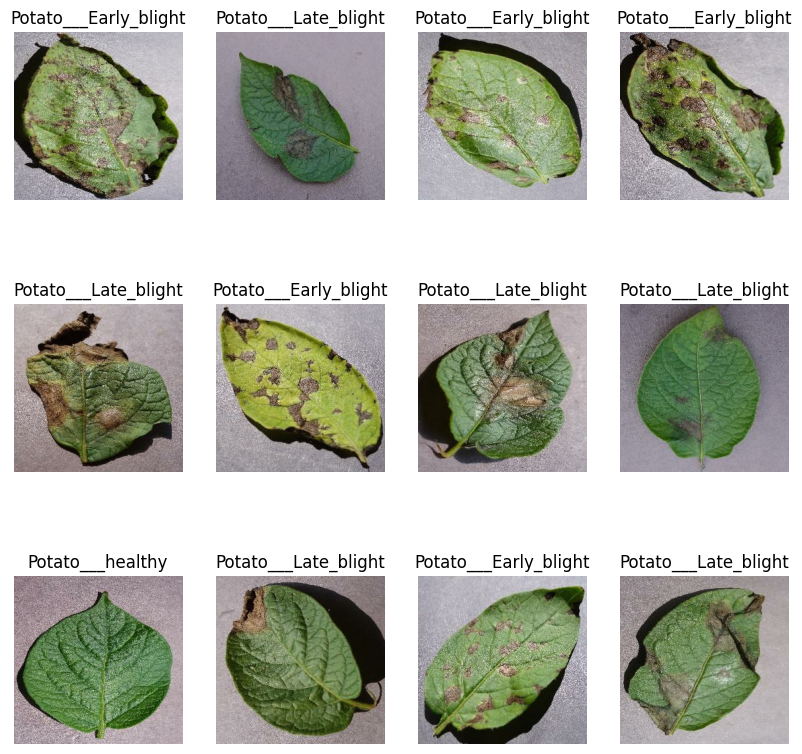

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

In [8]:

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)


54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)


14

In [11]:
val_size=0.1
len(dataset)*val_size


6.800000000000001

In [12]:

val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:

test_ds = test_ds.skip(6)
len(test_ds)


8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [15]:

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:

len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


C:\Users\Raj Nayan Mir\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.4397 - loss: 0.9583 - val_accuracy: 0.6719 - val_loss: 0.7034
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.7001 - loss: 0.6738 - val_accuracy: 0.8073 - val_loss: 0.5105
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.7942 - loss: 0.4930 - val_accuracy: 0.9010 - val_loss: 0.2745
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.8748 - loss: 0.2960 - val_accuracy: 0.9271 - val_loss: 0.1896
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.9113 - loss: 0.2431 - val_accuracy: 0.9479 - val_loss: 0.1361
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.9292 - loss: 0.1834 - val_accuracy: 0.9531 - val_loss: 0.1262
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 954ms/step - accuracy: 0.9296 - loss: 0.2068 - val_accuracy: 0.9740 - val_loss: 0.0849
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 786ms/step - accuracy: 0.9347 - loss: 0.1651 - val_accuracy: 0.9219

In [27]:
score = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - accuracy: 0.9917 - loss: 0.0234


In [28]:
history

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


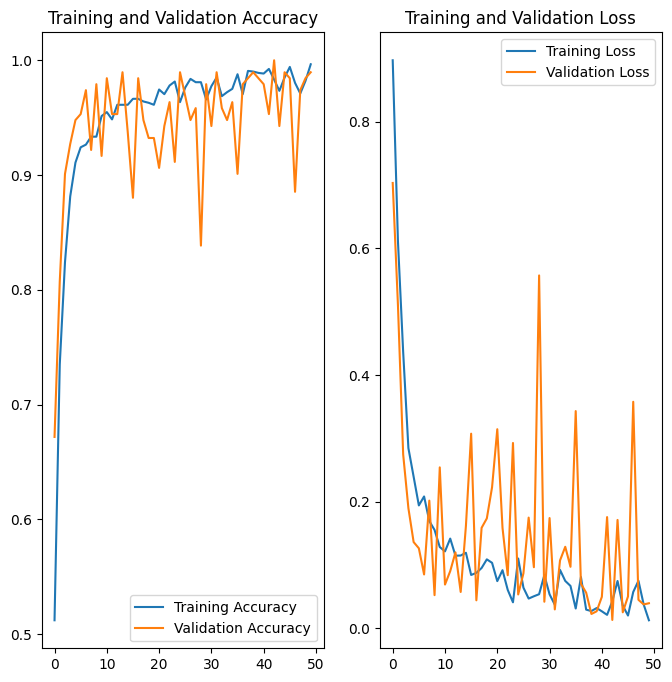

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
predicted label: Potato___Late_blight


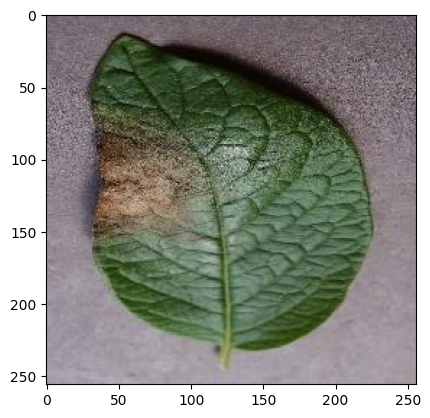

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


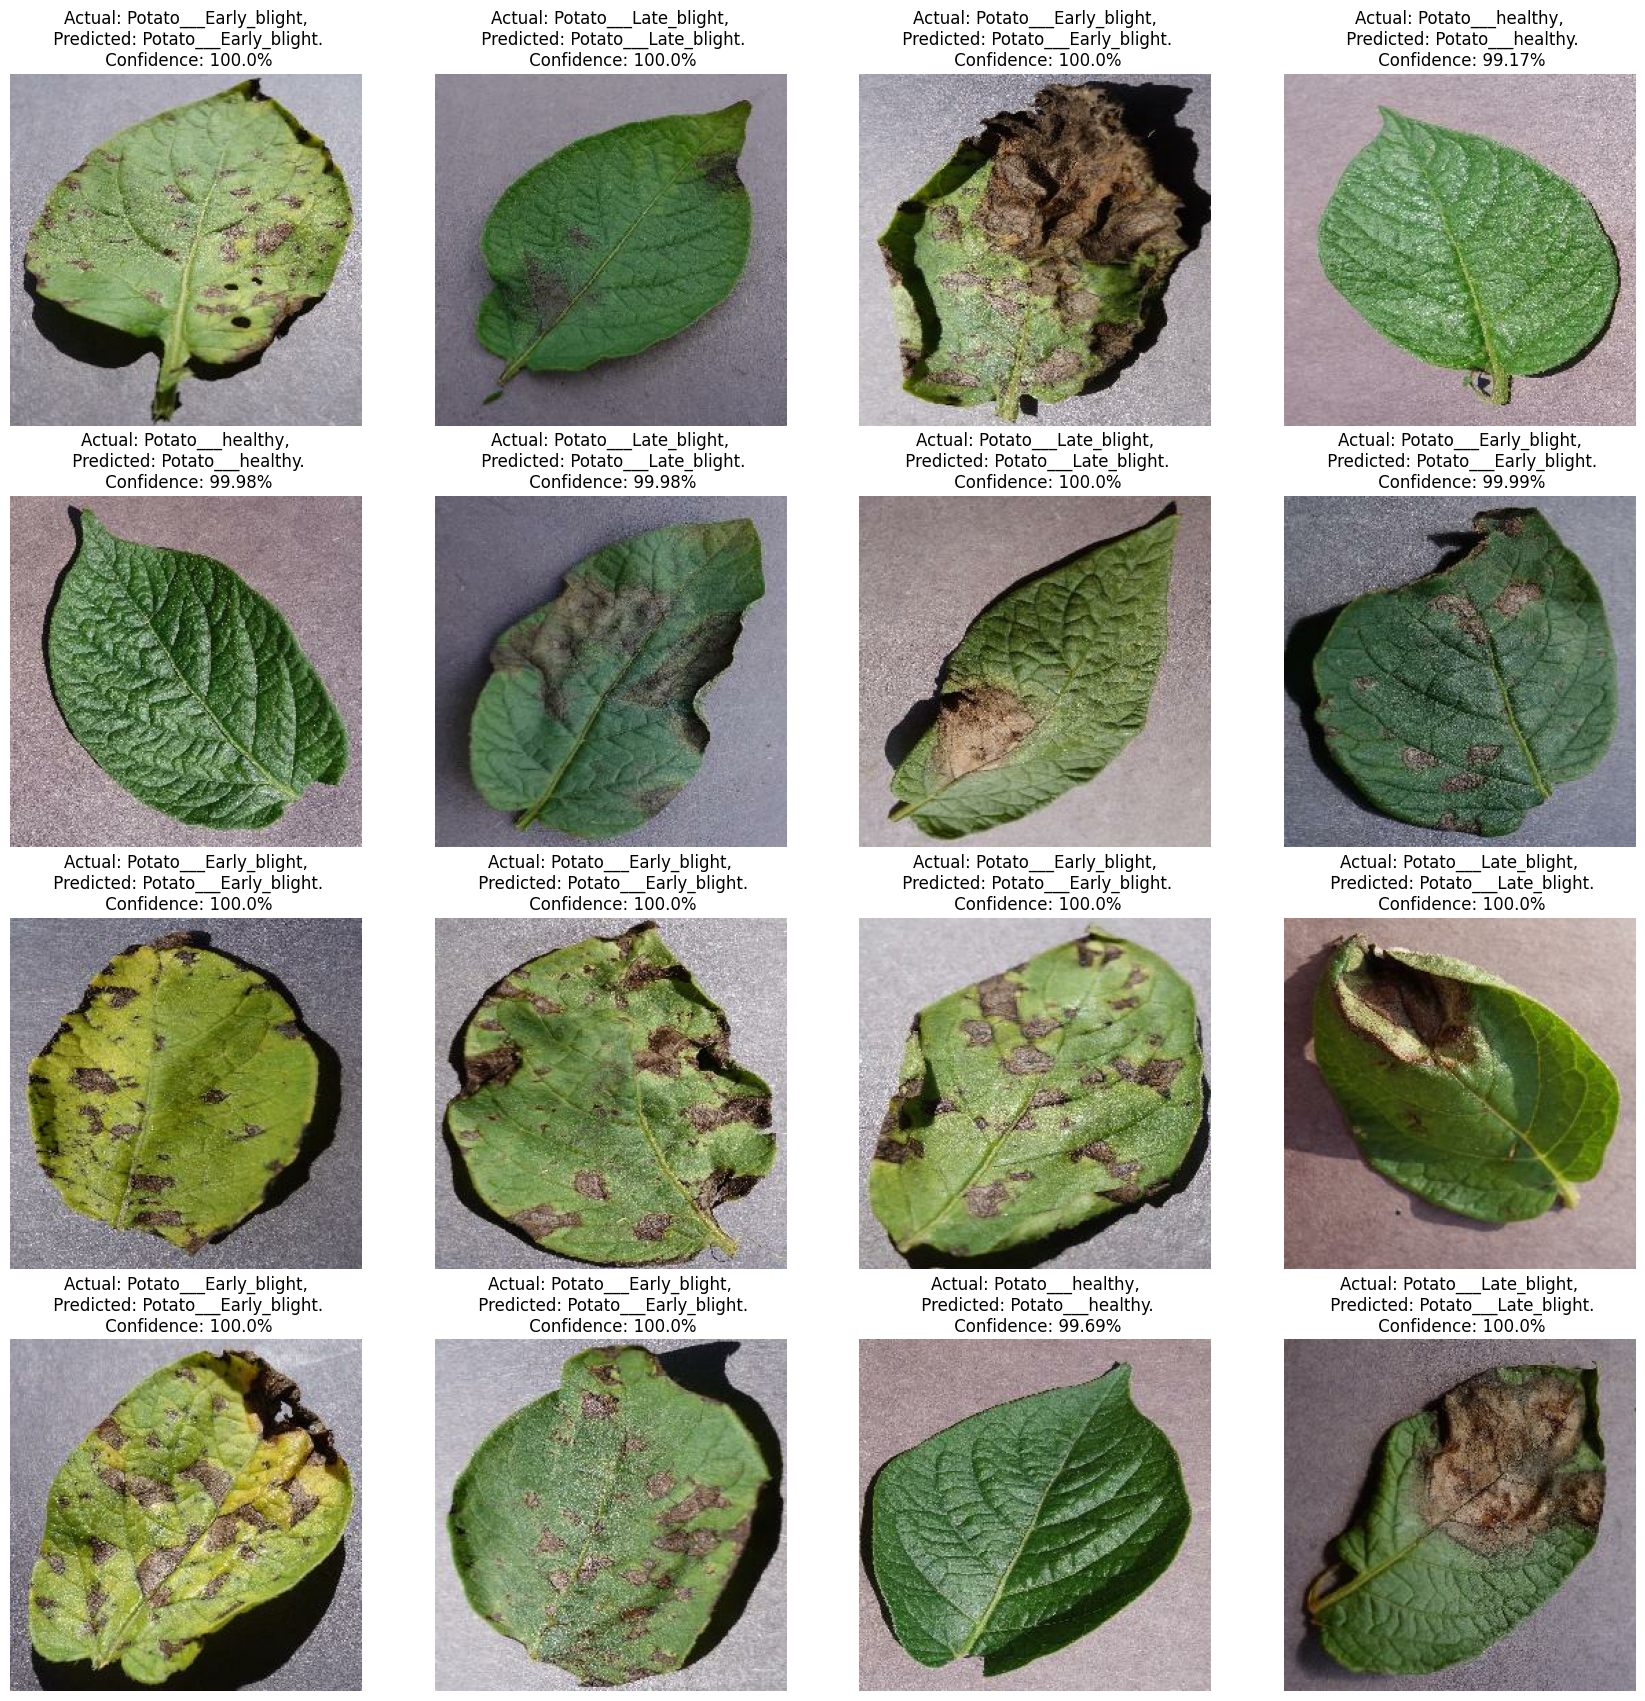

In [34]:
plt.figure(figsize=(21, 21))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [35]:
'''
import os

# Path to the saved_models directory
base_path = "../saved_models"

# List only numeric folders (model versions)
model_versions = [int(i) for i in os.listdir(base_path) if i.isdigit()]

# Next model version number
model_version = max(model_versions + [0]) + 1

# Create full export path
export_path = os.path.join(base_path, str(model_version))

# Export model in SavedModel format (required by TensorFlow Serving)
model.export(export_path)
'''

'\nimport os\n\n# Path to the saved_models directory\nbase_path = "../saved_models"\n\n# List only numeric folders (model versions)\nmodel_versions = [int(i) for i in os.listdir(base_path) if i.isdigit()]\n\n# Next model version number\nmodel_version = max(model_versions + [0]) + 1\n\n# Create full export path\nexport_path = os.path.join(base_path, str(model_version))\n\n# Export model in SavedModel format (required by TensorFlow Serving)\nmodel.export(export_path)\n'

In [36]:
'''
import os

# Create models directory if it doesn't exist
os.makedirs("../model.keras", exist_ok=True)

# Extract version numbers from filenames like '1.keras'
existing_versions = []
for filename in os.listdir("../model.keras"):
    name, ext = os.path.splitext(filename)
    if name.isdigit() and ext in [".keras", ".h5"]:
        existing_versions.append(int(name))

# Default to 0 if no valid files found
model_version = max(existing_versions + [0]) + 1

# Save the model with the new version
model.save(f"../model.keras/{model_version}.keras")
'''

'\nimport os\n\n# Create models directory if it doesn\'t exist\nos.makedirs("../model.keras", exist_ok=True)\n\n# Extract version numbers from filenames like \'1.keras\'\nexisting_versions = []\nfor filename in os.listdir("../model.keras"):\n    name, ext = os.path.splitext(filename)\n    if name.isdigit() and ext in [".keras", ".h5"]:\n        existing_versions.append(int(name))\n\n# Default to 0 if no valid files found\nmodel_version = max(existing_versions + [0]) + 1\n\n# Save the model with the new version\nmodel.save(f"../model.keras/{model_version}.keras")\n'

In [37]:
import os

def save_model_versioned(model, base_path="../saved_models"):
    # Ensure the directory exists
    os.makedirs(base_path, exist_ok=True)
    
    # Determine the next version number by checking existing folders
    existing_versions = [
        int(i) for i in os.listdir(base_path) if i.isdigit()
    ]
    model_version = max(existing_versions + [0]) + 1
    
    # Create version folder (e.g., saved_models/1/)
    version_folder = os.path.join(base_path, str(model_version))
    os.makedirs(version_folder, exist_ok=True)

    # Save the model as .keras file
    keras_model_path = os.path.join(version_folder, f"{model_version}.keras")
    model.save(keras_model_path)
    
    # Save the model as TensorFlow SavedModel (the full directory structure)
    saved_model_path = os.path.join(version_folder, "model")
    model.export(saved_model_path)

    print(f"Model saved in versioned folder: {version_folder}")
    print(f"  - .keras file: {keras_model_path}")
    print(f"  - SavedModel folder: {saved_model_path}")

# Example usage
save_model_versioned(model)


INFO:tensorflow:Assets written to: ../saved_models\1\model\assets


INFO:tensorflow:Assets written to: ../saved_models\1\model\assets


Saved artifact at '../saved_models\1\model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2324206655568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2324206656336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2324206654992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2324206657104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2324206658064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2324206657296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2324206656720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2324206659024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2324206658832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2324206659600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2324206657872: TensorSpec